# Preprocessing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Penn Treebank/Penn Treebank/Secs0-18 - training" #Ju

# GLOVE

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-07-08 20:30:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-08 20:30:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-08 20:30:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import numpy as np

In [ ]:
def load_glove_embeddings(glove_path, embedding_dim):
    embeddings_index = {}
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index


### Tokenization

In [ ]:
content = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        content.extend(pt)

In [ ]:
content_sentences = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        content_sentences.extend([pt])


### Building the Vocab

In [ ]:
word2idx = {'<PAD>': 0, '<UNK>': 1}
tag2idx = {'<PAD>': 0}

In [ ]:
for sent in content:
    word = sent[0]
    tag = sent[1]
    word2idx.setdefault(word.lower(), len(word2idx))
    tag2idx.setdefault(tag, len(tag2idx))

In [ ]:
def index_to_tag(tag2idx):
  return {i: t for t, i in tag2idx.items()}

In [ ]:
idx2tag = index_to_tag(tag2idx)

### Glove | Matriz Embedding

In [ ]:
glove_path = "glove.6B.100d.txt"
embedding_dim = 100
embeddings_index = load_glove_embeddings(glove_path, embedding_dim)

vocab = set([w.lower() for sent in content_sentences for (w, _) in sent])
filtered_vocab = [w for w in vocab if w in embeddings_index]
word2idx = {w: i + 2 for i, w in enumerate(filtered_vocab)}
word2idx['<PAD>'] = 0
word2idx['<UNK>'] = 1

embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, idx in word2idx.items():
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))


###  Encoding sentences

In [ ]:
def encode_sentence(sentence, word2idx, tag2idx):
  words_ids = [word2idx.get(word.lower(), word2idx['<UNK>']) for word,_ in sentence]
  tags_ids = [tag2idx[tag] for _,tag in sentence]
  return words_ids, tags_ids

In [ ]:
encoded_sentences = [encode_sentence(sentence,word2idx,tag2idx) for sentence in content_sentences]

### Padding

O padding é feito aqui porque o modelo só aceita entradas com o mesmo tamanho, por conta dos baches, então o padding serve para pegar a largura da maior sentença e preenche os outros que tem menos com </PAD/>(0) para normalizar

In [ ]:
import tensorflow as tf

In [ ]:
max_len = max(len(x[0]) for x in encoded_sentences)
X = tf.keras.preprocessing.sequence.pad_sequences([x[0] for x in encoded_sentences], maxlen=max_len, padding='post')
y = tf.keras.preprocessing.sequence.pad_sequences([x[1] for x in encoded_sentences], maxlen=max_len, padding='post')


In [ ]:
y

array([[ 1,  1,  2, ...,  0,  0,  0],
       [ 1,  1, 12, ...,  0,  0,  0],
       [ 1,  1,  2, ...,  0,  0,  0],
       ...,
       [ 3,  1,  1, ...,  0,  0,  0],
       [ 8,  1,  1, ...,  0,  0,  0],
       [19, 12, 17, ...,  0,  0,  0]], dtype=int32)

### Convert to Tensor

Para ser aceito pela rede neural

In [ ]:
# Convertendo para tensor
X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)

In [ ]:
X

<tf.Tensor: shape=(38219, 249), dtype=int32, numpy=
array([[ 4588,     1,  2131, ...,     0,     0,     0],
       [22240,     1,  9753, ...,     0,     0,     0],
       [26924, 15311,  2131, ...,     0,     0,     0],
       ...,
       [13629,  5903,  8968, ...,     0,     0,     0],
       [32077,  5903,  8968, ...,     0,     0,     0],
       [15617,  9753,  7741, ...,     0,     0,     0]], dtype=int32)>

# BiLSTM

### Validation Dataset

In [ ]:
path = "/content/drive/MyDrive/Penn Treebank/Penn Treebank/Secs19-21 - development" #Ju

In [ ]:
dev_sentences = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        dev_sentences.extend([pt])

In [ ]:
dev_sentences

[[('The', 'DT'),
  ('Arizona', 'NNP'),
  ('Corporations', 'NNP'),
  ('Commission', 'NNP'),
  ('authorized', 'VBD'),
  ('an', 'DT'),
  ('11.5', 'CD'),
  ('%', 'NN'),
  ('rate', 'NN'),
  ('increase', 'NN'),
  ('at', 'IN'),
  ('Tucson', 'NNP'),
  ('Electric', 'NNP'),
  ('Power', 'NNP'),
  ('Co.', 'NNP'),
  (',', ','),
  ('substantially', 'RB'),
  ('lower', 'JJR'),
  ('than', 'IN'),
  ('recommended', 'VBN'),
  ('last', 'JJ'),
  ('month', 'NN'),
  ('by', 'IN'),
  ('a', 'DT'),
  ('commission', 'NN'),
  ('hearing', 'NN'),
  ('officer', 'NN'),
  ('and', 'CC'),
  ('barely', 'RB'),
  ('half', 'PDT'),
  ('the', 'DT'),
  ('rise', 'NN'),
  ('sought', 'VBN'),
  ('by', 'IN'),
  ('the', 'DT'),
  ('utility', 'NN'),
  ('.', '.')],
 [('The', 'DT'),
  ('ruling', 'NN'),
  ('follows', 'VBZ'),
  ('a', 'DT'),
  ('host', 'NN'),
  ('of', 'IN'),
  ('problems', 'NNS'),
  ('at', 'IN'),
  ('Tucson', 'NNP'),
  ('Electric', 'NNP'),
  (',', ','),
  ('including', 'VBG'),
  ('major', 'JJ'),
  ('write-downs', 'NNS'),
  (

In [ ]:
import numpy as np

In [ ]:
encoded_sentences = [encode_sentence(sentence,word2idx,tag2idx) for sentence in dev_sentences]
max_len_development = max(len(x[0]) for x in encoded_sentences)
X_development = tf.keras.preprocessing.sequence.pad_sequences([x[0] for x in encoded_sentences], maxlen=max_len, padding='post')
y_development = tf.keras.preprocessing.sequence.pad_sequences([x[1] for x in encoded_sentences], maxlen=max_len, padding='post')
y_development = np.expand_dims(y_development, -1)

# Convertendo para tensor
X_development = tf.convert_to_tensor(X_development)
y_development = tf.convert_to_tensor(X_development)

### Model

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
vocab_size = len(word2idx)
num_tags = len(tag2idx)

model = models.Sequential([
    layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True, #Treinamos assim, mas o melhor seria ter colocado False
        mask_zero=False
    ),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.TimeDistributed(layers.Dense(num_tags, activation='softmax'))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, epochs=30, batch_size=128,
                    validation_data=(X_development, y_development), validation_freq=5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 63s 150ms/step - accuracy: 0.9244 - loss: 0.3262
Epoch 2/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 77s 147ms/step - accuracy: 0.9924 - loss: 0.0303
Epoch 3/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - accuracy: 0.9952 - loss: 0.0169
Epoch 4/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 82s 147ms/step - accuracy: 0.9960 - loss: 0.0130
Epoch 5/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 86s 161ms/step - accuracy: 0.9966 - loss: 0.0109 - val_accuracy: 0.9054 - val_loss: nan
Epoch 6/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 78s 147ms/step - accuracy: 0.9969 - loss: 0.0096
Epoch 7/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - accuracy: 0.9971 - loss: 0.0088
Epoch 8/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 82s 147ms/step - accuracy: 0.9974 - loss: 0.0080
Epoch 9/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 82s 147ms/step - accuracy: 0.9976 - loss: 0.0073
Epoch 10/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 45s 152ms/step - accuracy: 0.9977 - loss: 0.0068 - val_accuracy: 0.9052 - val_loss: nan
Epoch 11/30
299/299 ━━━━━━━━━━━

In [ ]:
history.history

{'accuracy': [0.9635406136512756,
  0.9933615326881409,
  0.9953508973121643,
  0.9961207509040833,
  0.9965807795524597,
  0.9968910813331604,
  0.9971289038658142,
  0.9973387122154236,
  0.9975228309631348,
  0.9976853132247925,
  0.9978407621383667,
  0.9979757070541382,
  0.9981117248535156,
  0.998254120349884,
  0.9983711242675781,
  0.9984918236732483,
  0.9986134767532349,
  0.9987141489982605,
  0.9988371729850769,
  0.9989571571350098,
  0.9990499019622803,
  0.9991552829742432,
  0.9992650151252747,
  0.999350905418396,
  0.9994497299194336,
  0.9995272755622864,
  0.9996214509010315,
  0.9996821284294128,
  0.9997189044952393,
  0.9997740983963013],
 'loss': [0.1547171026468277,
  0.025494122877717018,
  0.015979958698153496,
  0.012638584710657597,
  0.010826480574905872,
  0.009621701203286648,
  0.008729778230190277,
  0.008006609044969082,
  0.007424416020512581,
  0.006835202220827341,
  0.006378610618412495,
  0.005952546838670969,
  0.005548686254769564,
  0.0051593

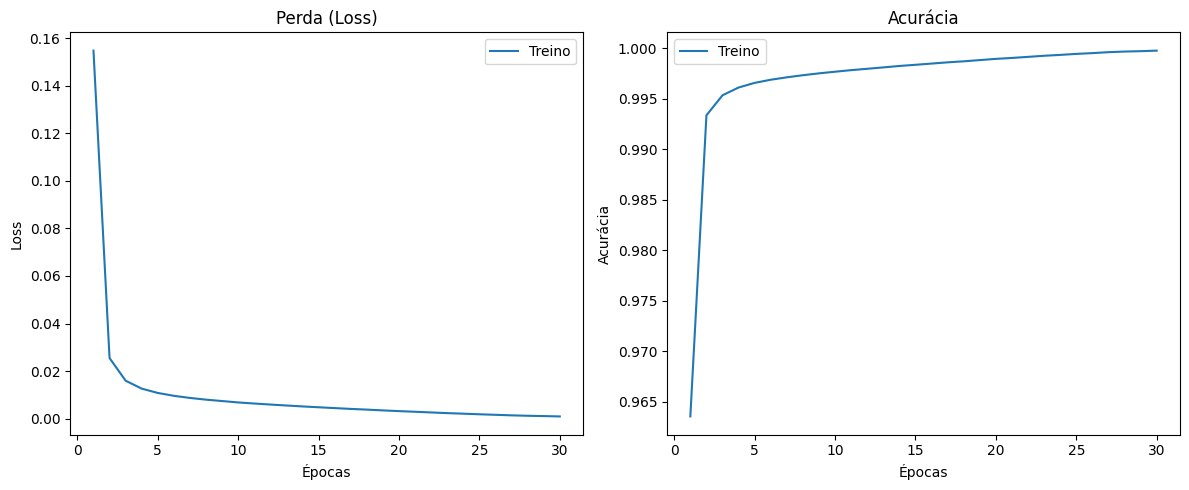

In [ ]:
import matplotlib.pyplot as plt

# Extrai os dados do histórico
hist = history.history
epochs = range(1, len(hist['loss']) + 1)

# 📉 Perda (loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, hist['loss'], label='Treino')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# 📊 Acurácia (accuracy), se disponível
plt.subplot(1, 2, 2)
if 'accuracy' in hist:
    plt.plot(epochs, hist['accuracy'], label='Treino')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow.keras as keras

In [ ]:
model.save("bilstm_glove.keras")

# Load model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("bilstm_glove.keras")

In [ ]:
model.compiled_metrics

<keras.src.backend.tensorflow.trainer.TensorFlowTrainer.compiled_metrics.<locals>.DeprecatedCompiledMetric at 0x7c757dee2e50>

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 249, 100)       │     3,302,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 249, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 249, 46)        │        11,822 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,647,056 (40.62 MB)

 Trainable params: 3,549,018 (13.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,098,038 (27.08 MB)

## Predict

In [ ]:
path = "/content/drive/MyDrive/Penn Treebank/Penn Treebank/Secs22-24 - testing" #Ju

In [ ]:
sentences_test = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        sentences_test.extend(pt)

In [ ]:
sentences_dataset_spplited = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        sentences_dataset_spplited.extend([pt])

In [ ]:
import numpy as np

In [ ]:
def predict_tags(model, sentences, word2idx, idx2tag):
    # Extrair só as palavras da sentença
    words = [w for w, _ in sentences]

    # Converter as palavras para índices
    word_ids = [word2idx.get(w.lower(), word2idx['<UNK>']) for w in words]

    # Fazer padding
    padded = tf.keras.preprocessing.sequence.pad_sequences([word_ids], maxlen=max_len, padding='post')
    padded = tf.convert_to_tensor(padded, dtype=tf.int32)

    # Prever
    pred = model.predict(padded)[0]
    pred_tags = [idx2tag[np.argmax(p)] for p in pred[:len(words)]]

    return list(zip(words, pred_tags))


Never run the cell bellow with all the sentences_text list. Because dataset's test has about 130k data.

In [ ]:
y_true = []
y_pred = []

for sentence in sentences_dataset_spplited[:20000]:  # Cada item é uma frase: [('The', 'DT'), ('cat', 'NN'), ...]
    true_tags = [tag for _, tag in sentence]
    predicted_tags = [tag for _, tag in predict_tags(model, sentence, word2idx, idx2tag)]

    y_true.extend(true_tags)
    y_pred.extend(predicted_tags)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
len(y_true)
len(y_pred)

25120

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

#print(classification_report(y_true, y_pred, digits=4))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 macro:", f1_score(y_true, y_pred, average='macro'))


Accuracy: 0.9458996815286624
F1 macro: 0.8635096234881463


/tmp/ipython-input-44-3175798811.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


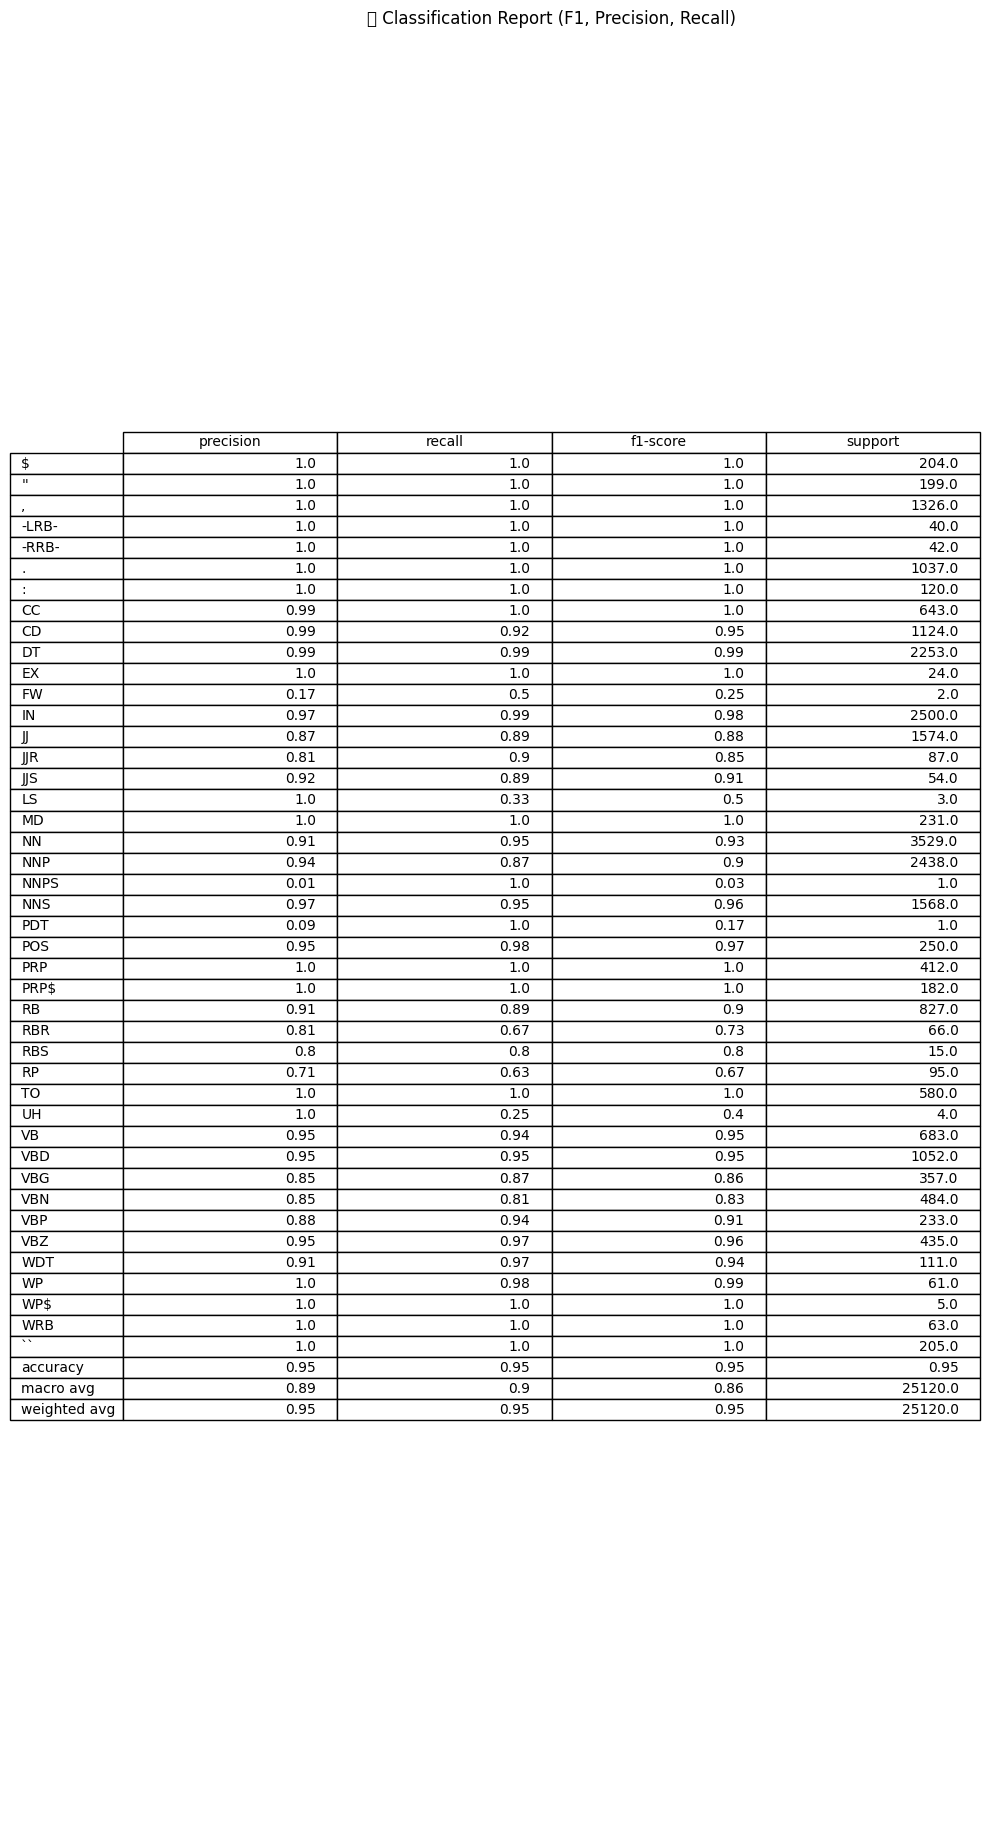

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(y_true, y_pred, digits=4, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

fig, ax = plt.subplots(figsize=(10, len(df_report) * 0.4))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_report.round(2).values,
         colLabels=df_report.columns,
         rowLabels=df_report.index,
         loc='center')
plt.title("📊 Classification Report (F1, Precision, Recall)")
plt.tight_layout()
plt.show()




/tmp/ipython-input-45-1207889945.py:7: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


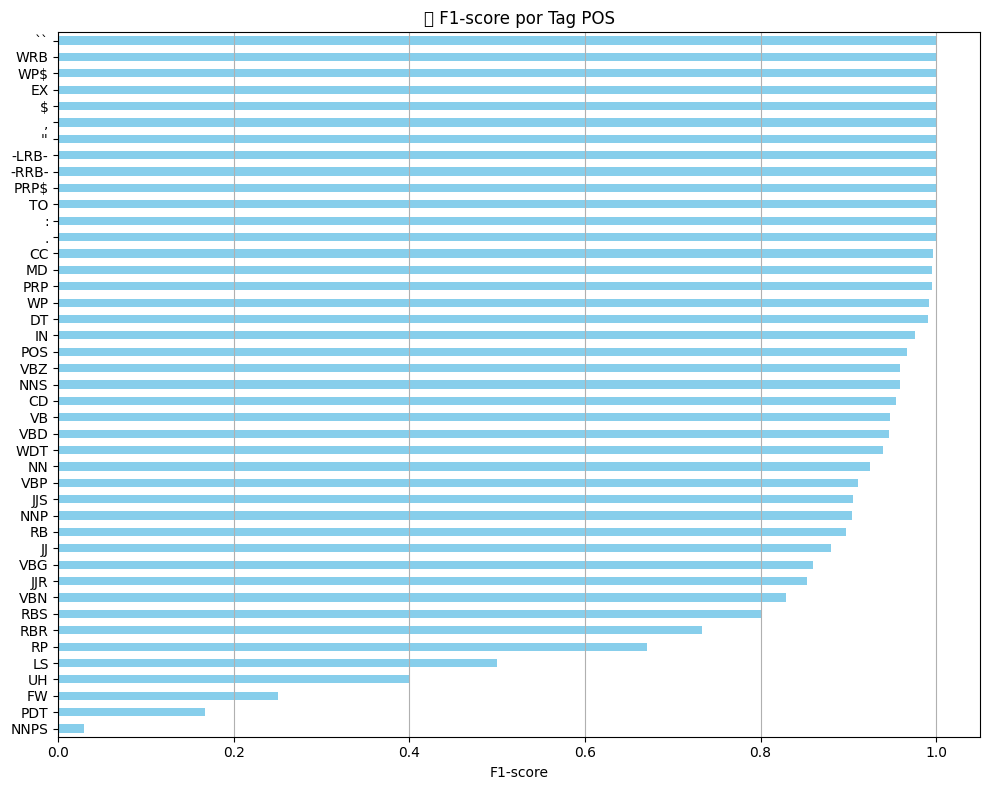

In [ ]:
f1_per_class = df_report.loc[df_report.index.str.len() <= 5].drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')['f1-score']

f1_per_class.sort_values().plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.xlabel("F1-score")
plt.title("📌 F1-score por Tag POS")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt


/tmp/ipython-input-46-489268921.py:13: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


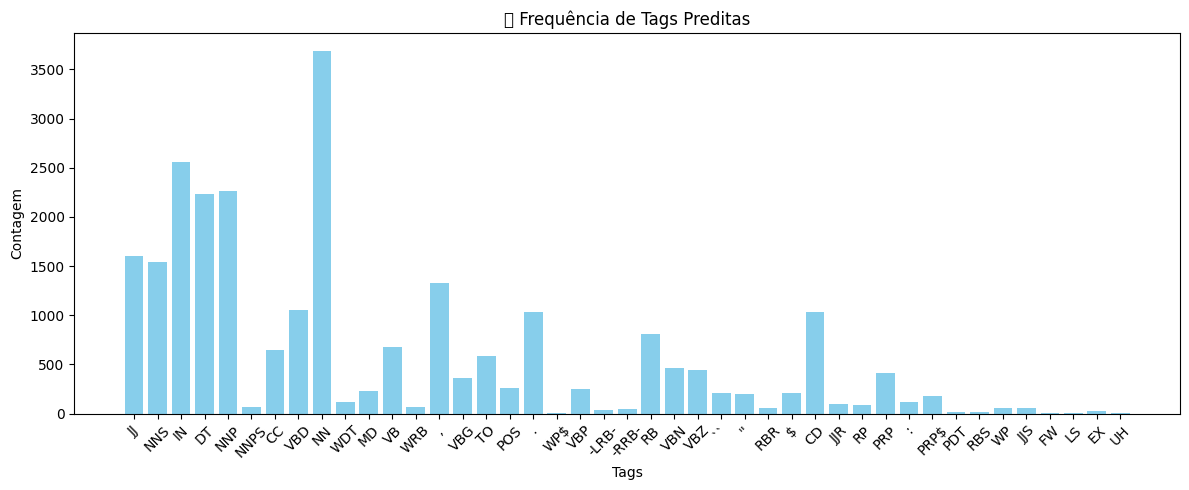

In [ ]:
from collections import Counter

# Conta as tags preditas
tag_counts = Counter(y_pred)

# Plota gráfico de barras
plt.figure(figsize=(12, 5))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
plt.title("📌 Frequência de Tags Preditas")
plt.xlabel("Tags")
plt.ylabel("Contagem")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-47-2512374719.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


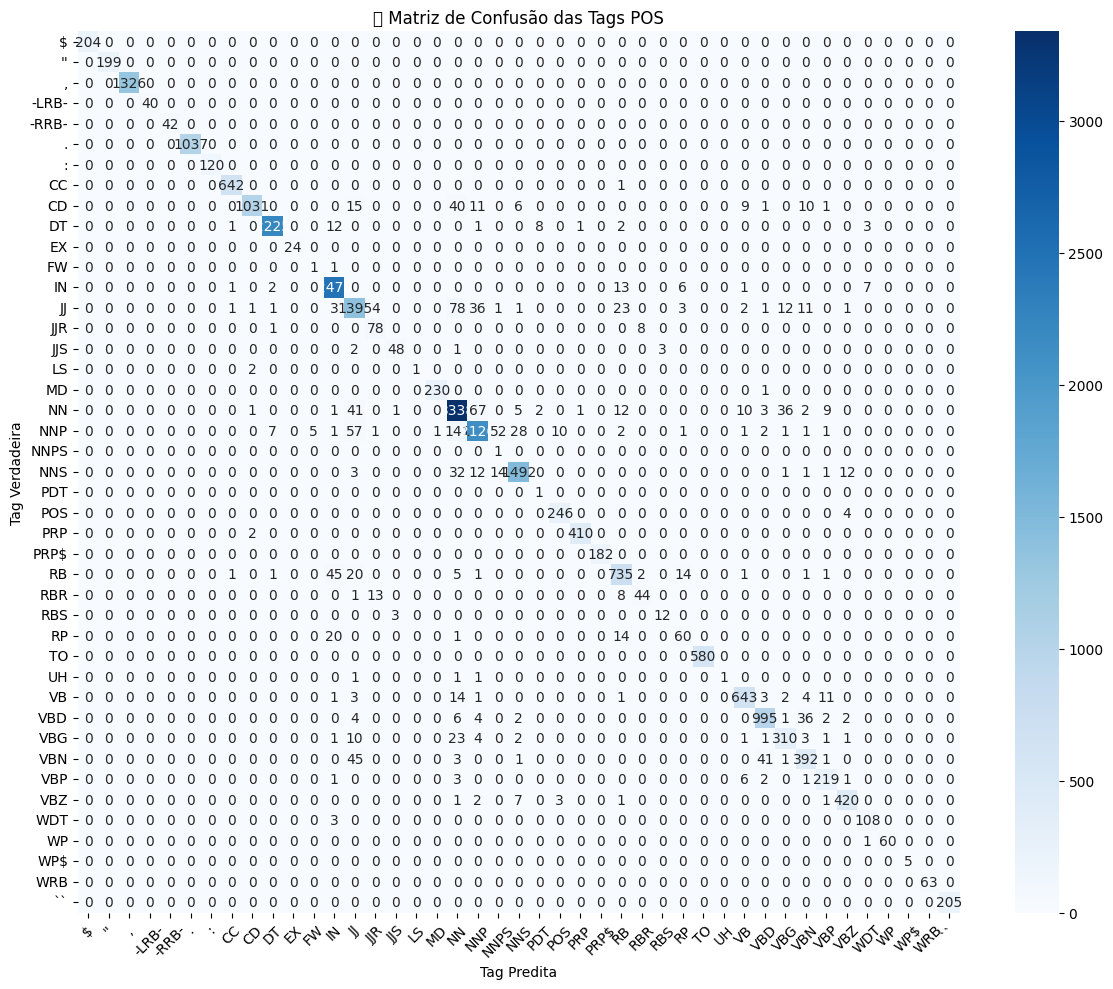

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cria matriz de confusão
cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true + y_pred)))

# Nomes das tags
labels = sorted(set(y_true + y_pred))

# Plot usando seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Tag Predita")
plt.ylabel("Tag Verdadeira")
plt.title("📊 Matriz de Confusão das Tags POS")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
